<a href="https://colab.research.google.com/github/coke819/codeit_project/blob/main/%ED%96%89%EB%8F%99%EC%8B%9C%ED%80%80%EC%8A%A4_%EB%B6%84%EC%84%9D_%EB%AF%BC%EC%A3%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [206]:
import pandas as pd
!pip install koreanize-matplotlib

In [207]:
!pip install pyarrow

## '하트잔여' 컬럼을 활용하여 충전 전후 행동 흐름 찾기

In [208]:
import pandas as pd
df= pd.read_parquet('/content/drive/MyDrive/고급프로젝트/final.parquet')

In [209]:
DF = df[['user_id', 'event_key', 'event_datetime', 'heart_balance']].copy()
DF = df.sort_values(['user_id', 'event_datetime'])

#이전 하트 잔액, 이벤트 키, 시간 계산
DF['heart_balance_prev'] = DF.groupby('user_id')['heart_balance'].shift(1)
DF['event_key_prev'] = DF.groupby('user_id')['event_key'].shift(1)
DF['event_datetime_prev'] = DF.groupby('user_id')['event_datetime'].shift(1)

#변화량 계산 공식
DF['heart_balance_diff'] = DF['heart_balance'] - DF['heart_balance_prev']

#NaN 이전 값을 채우기
DF['heart_balance'] = DF['heart_balance'].fillna(method='ffill')

#NaN 제거 & 변화가 있는 경우만 골라내기
result_DF = DF[
    DF['heart_balance_diff'].notnull() &
    (DF['heart_balance_diff'] != 0)
].copy()



#원하는 컬럼만 정리
result_DF = result_DF[[
    'user_id',
    'event_key_prev', 'event_datetime_prev', 'heart_balance_prev',
    'event_key', 'event_datetime', 'heart_balance',
    'heart_balance_diff'
]]

result_DF.head()

/tmp/ipython-input-209-3342473611.py:13: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,user_id,event_key_prev,event_datetime_prev,heart_balance_prev,event_key,event_datetime,heart_balance,heart_balance_diff
7119300,1000013,view_login,2023-07-20 01:04:42,3688.0,click_bottom_navigation_timeline,2023-07-20 01:04:57,3718.0,30.0
1393712,1000030,view_shop,2023-07-29 01:01:09,771.0,click_purchase,2023-07-29 01:01:11,547.0,-224.0
1393656,1000030,launch_app,2023-07-30 15:55:00,547.0,click_attendance,2023-07-30 15:55:03,771.0,224.0
3282467,1000044,launch_app,2023-07-18 18:08:53,1136.0,launch_app,2023-07-18 22:57:35,883.0,-253.0
9573354,1000069,view_shop,2023-07-20 21:53:46,1058.0,launch_app,2023-07-20 21:54:47,571.0,-487.0


In [210]:
# 충전 전후 행동쌍 만들어서 개수 집계
charge_df = result_DF[result_DF['heart_balance_diff'] > 0].copy()
charge_df['prev_event'] = charge_df['event_key_prev']
# 충전 후 이벤트
charge_df['next_event'] = charge_df['event_key']
transition_counts = charge_df.groupby(['prev_event', 'next_event']).size().reset_index(name='count')

# count 기준으로 상위 10개 보기
top_transitions= transition_counts.sort_values(by='count', ascending=False).head(10)

top_transitions

,prev_event,next_event,count
181,view_login,click_question_open,7636
220,view_shop,click_purchase,2770
144,launch_app,click_question_open,2322
170,view_login,click_appbar_alarm_center,2185
182,view_login,click_question_start,1462
191,view_login,view_timeline_tap,1296
146,launch_app,click_question_start,1185
177,view_login,click_bottom_navigation_questions,1096
31,$session_start,click_question_open,1072
135,launch_app,click_attendance,1054


In [211]:
import plotly.graph_objects as go

# 전체 노드 리스트 만들기
all_nodes = list(set(top_transitions['prev_event']).union(set(top_transitions['next_event'])))
node_indices = {node: i for i, node in enumerate(all_nodes)}

# 노드 인덱스 매핑
source_indices = top_transitions['prev_event'].map(node_indices)
target_indices = top_transitions['next_event'].map(node_indices)
values = top_transitions['count']

# Sankey 다이어그램 생성
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=all_nodes,
        color= ['#14213d','#fca311','#e5e5e5','#ffffff','#2b2d42'] *10
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values
    ))])

fig.update_layout(title_text="충전 전후 행동 전이 (Transition Sankey)", font_size=17)
fig.show()

In [212]:
import pandas as pd

top_prev = transition_counts['prev_event'].value_counts().head(10).index
top_next = transition_counts['next_event'].value_counts().head(10).index

filtered_heatmap = transition_counts[
    transition_counts['prev_event'].isin(top_prev) &
    transition_counts['next_event'].isin(top_next)
]

# 피벗 테이블 (cross-tab 형태로)
heatmap_data = pd.pivot_table(
    filtered_heatmap,
    values='count',
    index='prev_event',
    columns='next_event',
    aggfunc='sum',
    fill_value=0
)

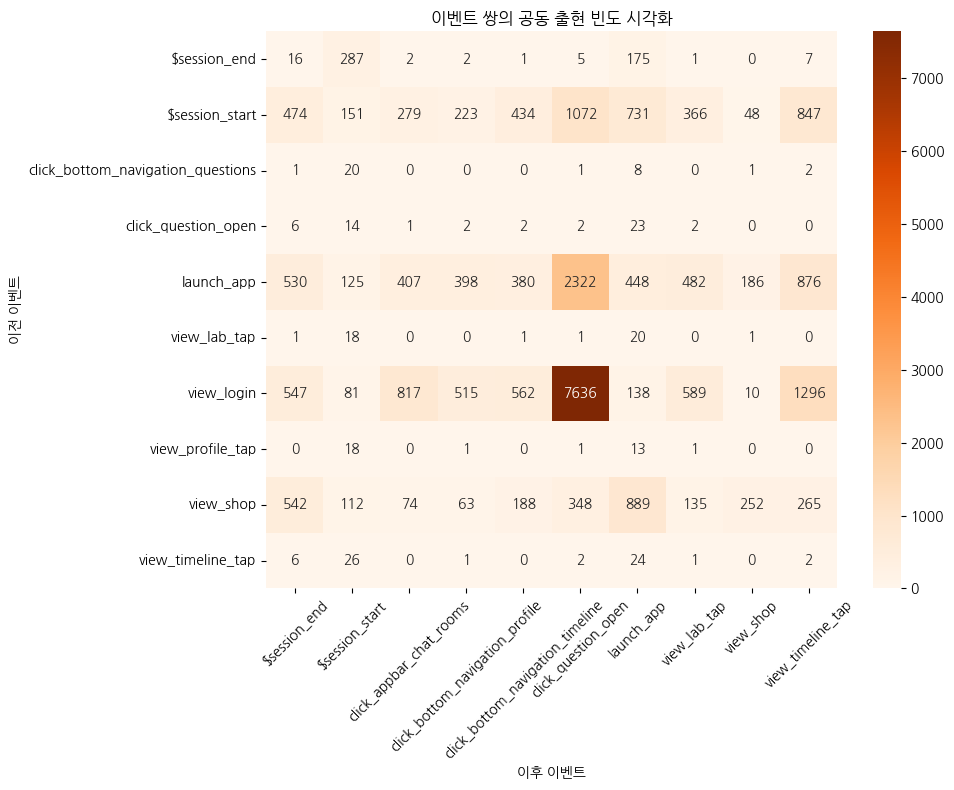

In [213]:
# 어떤 이벤트 뒤에 주로 어떤 이벤트가 따라오는가
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Oranges')

plt.title("이벤트 쌍의 공동 출현 빈도 시각화")
plt.xlabel("이후 이벤트")
plt.ylabel("이전 이벤트")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [214]:
# 충전 전후 행동량의 차이를 통해 변화량 확인
# 충전 전 행동 분포
prev_behavior_counts = charge_df['event_key_prev'].value_counts(normalize=True)

# 충전 후 행동 분포
next_behavior_counts = charge_df['event_key'].value_counts(normalize=True)

# 변화량 정리
behavior_change = (next_behavior_counts - prev_behavior_counts).sort_values(ascending=False)
behavior_change

,proportion
click_question_open,0.254523
click_appbar_alarm_center,0.082125
click_question_start,0.082013
view_timeline_tap,0.072541
click_attendance,0.071127
click_purchase,0.062284
click_bottom_navigation_questions,0.057032
$session_end,0.036136
click_appbar_chat_rooms,0.035014
click_bottom_navigation_timeline,0.034812


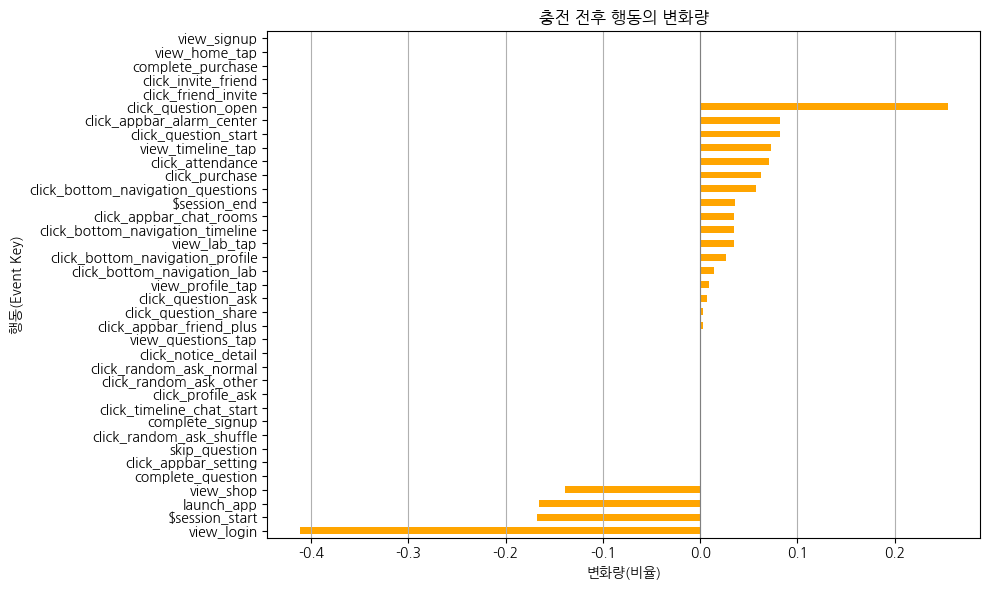

In [215]:
# 충전 전후 이벤트 변화량 시각화
import koreanize_matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
behavior_change.sort_values().plot(kind='barh', color='Orange')
plt.axvline(0, color='gray', linewidth=0.8)
plt.title('충전 전후 행동의 변화량')
plt.xlabel('변화량(비율)')
plt.ylabel('행동(Event Key)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

## 충전 전후 이벤트의 행동 흐름을 통한 군집 분석 및 시각화

In [216]:
user_sequences = (
    df
    .sort_values(['user_id', 'event_datetime'])
    .groupby('user_id')['event_key']
    .apply(list)
    .reset_index()
)
user_sequences['user_str']= user_sequences['event_key'].apply(lambda x: '>'.join(x))

In [217]:
#문자열 시퀀스를 숫자 벡터로 변환
# TF-IDF란? 는 흔한 행동은 가중치를 줄이고, 드문 행동은 가중치를 높이는 것=> 각 세션을 행동 기반의 고차원 벡터로 바꿔주는 작업
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(user_sequences['user_str'])

In [218]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
user_sequences['cluster'] = kmeans.fit_predict(X)

In [219]:
for c in sorted(user_sequences['cluster'].unique()):
    print(f"\nCluster {c} 대표 시퀀스:")
    print(user_sequences[user_sequences['cluster'] == c]['user_str'].head(3).to_string(index=False))


Cluster 0 대표 시퀀스:
launch_app>$session_start>click_question_open>c...
launch_app>click_bottom_navigation_timeline>cli...
launch_app>$session_start>launch_app>launch_app...

Cluster 1 대표 시퀀스:
launch_app>$session_start>$session_end>$session...
$session_start>launch_app>click_question_open>c...
launch_app>$session_start>$session_end>$session...

Cluster 2 대표 시퀀스:
$session_start>launch_app
launch_app>$session_start
launch_app>$session_start

Cluster 3 대표 시퀀스:
           launch_app>$session_start>view_home_tap
launch_app>$session_start>$session_end>launch_a...
launch_app>$session_start>view_home_tap>$sessio...

Cluster 4 대표 시퀀스:
$session_end>$session_start>launch_app>$session...
$session_start>launch_app>$session_end>launch_a...
launch_app>$session_end>$session_start>$session...


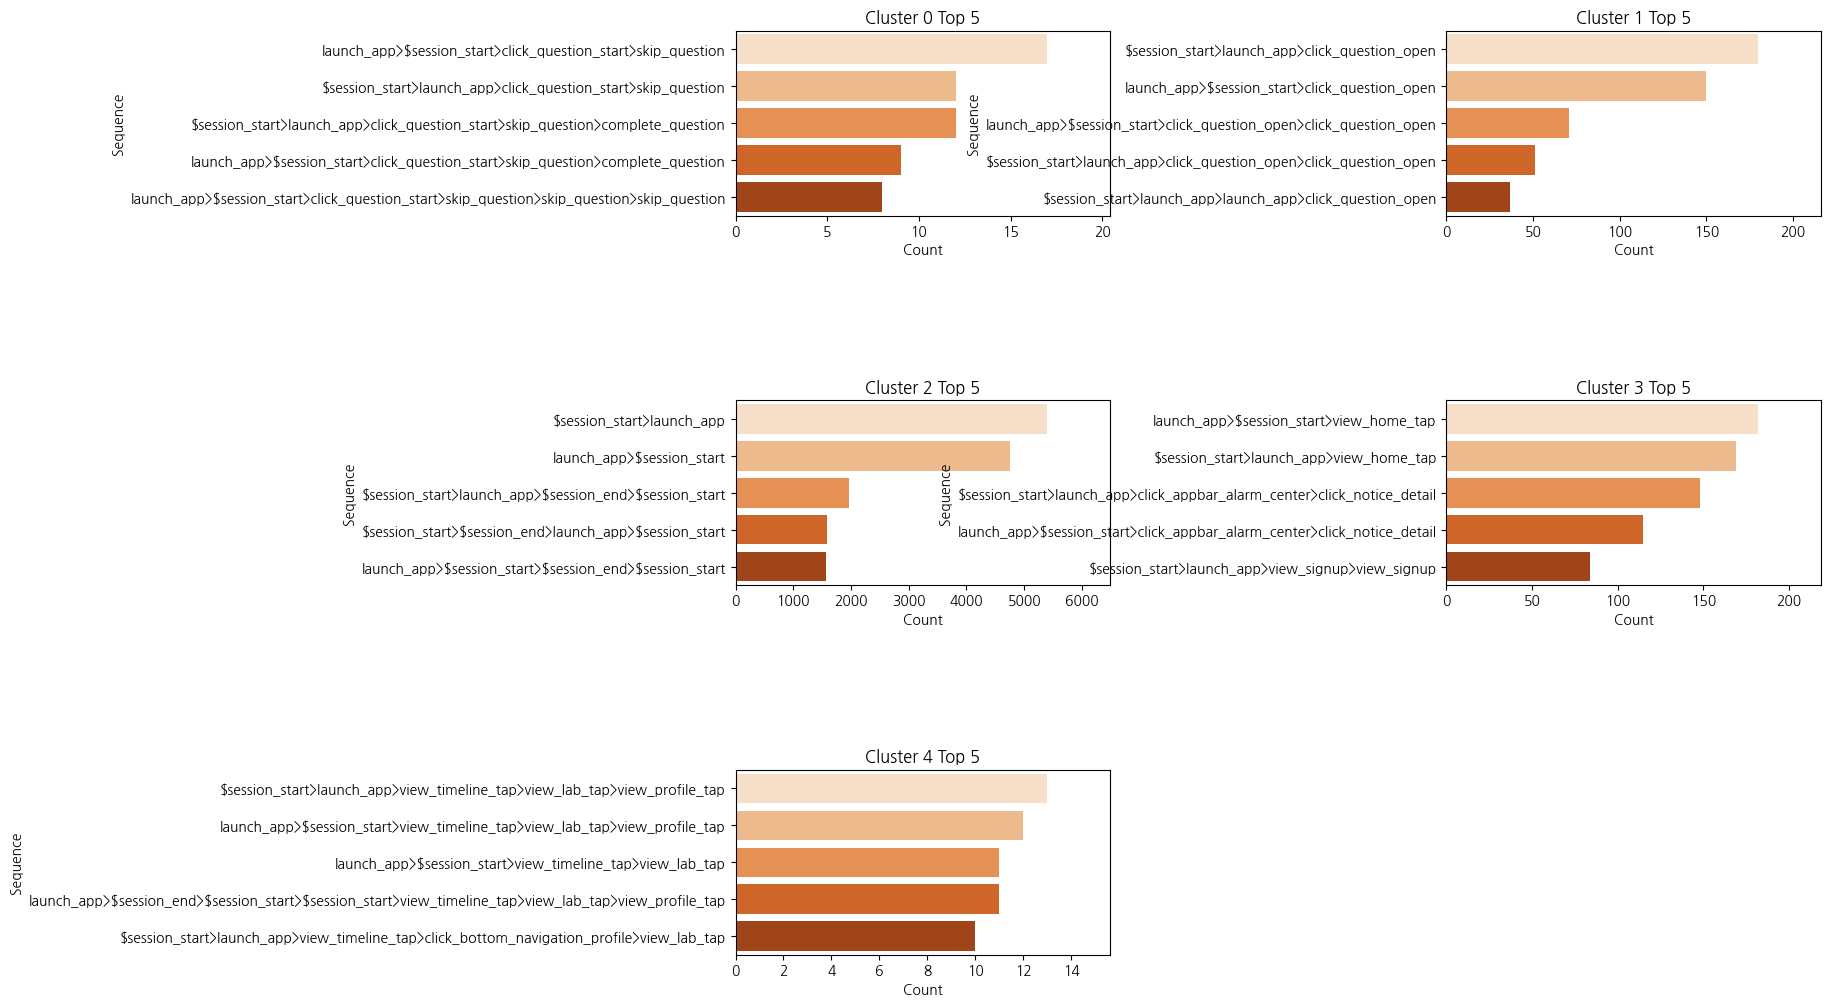

In [220]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# user_sequences에는 다음 컬럼이 있다고 가정: cluster, user_str

def visualize_cluster_sequences_grid(user_sequences, top_n=5, n_cols=3):
    clusters = sorted(user_sequences['cluster'].unique())
    n_clusters = len(clusters)

    # subplot 크기 자동 계산
    n_rows = math.ceil(n_clusters / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 4*n_rows))
    axes = axes.flatten()

    for idx, c in enumerate(clusters):
        cluster_data = user_sequences[user_sequences['cluster'] == c]
        top_seq = cluster_data['user_str'].value_counts().head(top_n)

        sns.barplot(
            x=top_seq.values, y=top_seq.index, ax=axes[idx],
            hue=top_seq.index, palette="Oranges", dodge=False, legend=False
        )
        axes[idx].set_title(f"Cluster {c} Top {top_n}")
        axes[idx].set_xlabel("Count")
        axes[idx].set_ylabel("Sequence")
        axes[idx].set_xlim(0, top_seq.values.max() * 1.2)
    # 빈 subplot 숨기기
    for ax in axes[len(clusters):]:
        ax.axis('off')

    plt.subplots_adjust(hspace= 1.0, wspace=0.9)
    plt.show()


# 실행 예시
visualize_cluster_sequences_grid(user_sequences, top_n=5, n_cols=2)

## 클러스터에 유저의 특성을 더하고 시각화하기

In [221]:
user_cluster_mapping = user_sequences[['user_id', 'cluster']]
user_cluster_mapping

,user_id,cluster
0,012Si5t33QgB3g18oOpcd2RDx5U2,2
1,01BFWYlo11eFmY64kiY6n5PQAcs1,2
2,01pPQO7oPmgKZOU7f8XGc93rCWg2,2
3,02Ika66GtzVQj5Epl6xtwcGf72u1,2
4,02QVyNBCraNN7i04MPRQVrGbGPR2,2
...,...,...
239645,zy74pTORXyYJPQ9DVIg42cYFpuE3,2
239646,zyZTSupKTMaxZyJKmilGZNMmsMh2,2
239647,zyk1fC4t2BW230b2pB1AvD5Y2rk2,2
239648,zzc8rg7phYQqQDm8EWia0ZMMxLE2,2


In [222]:
# 가입일
signup_date = df.groupby('user_id')['event_datetime'].min().reset_index().rename(columns={'event_datetime': 'signup_date'})

# 최근 접속일
last_login = df.groupby('user_id')['event_datetime'].max().reset_index().rename(columns={'event_datetime': 'last_login'})

# 이벤트 수 (활동량)
event_count = df.groupby('user_id').size().reset_index(name='event_count')

# friend_count (마지막 friend_count로 대체)
friend_count = df.groupby('user_id')['friend_count'].last().reset_index()

# 디바이스 OS 정보 (마지막 사용 OS)
os_info = df.groupby('user_id')[['osname', 'osversion']].last().reset_index()

# user_profile 종합
user_profile = signup_date.merge(last_login, on='user_id') \
                           .merge(event_count, on='user_id') \
                           .merge(friend_count, on='user_id') \
                           .merge(os_info, on='user_id')

# 확인
user_profile.head()

,user_id,signup_date,last_login,event_count,friend_count,osname,osversion
0,012Si5t33QgB3g18oOpcd2RDx5U2,2023-07-25 12:59:58,2023-07-25 12:59:58,2,NaN,Android,12
1,01BFWYlo11eFmY64kiY6n5PQAcs1,2023-07-18 20:45:12,2023-07-18 20:45:12,2,NaN,iOS,16.5.1
2,01pPQO7oPmgKZOU7f8XGc93rCWg2,2023-07-25 22:15:41,2023-07-25 22:15:41,2,NaN,iOS,16.4
3,02Ika66GtzVQj5Epl6xtwcGf72u1,2023-07-20 21:59:56,2023-07-20 21:59:56,2,NaN,iOS,16.0
4,02QVyNBCraNN7i04MPRQVrGbGPR2,2023-07-21 08:59:54,2023-07-24 00:01:15,6,NaN,Android,11


In [223]:
merged_df= pd.merge(user_cluster_mapping, user_profile, on= 'user_id',how= 'left')
merged_df

,user_id,cluster,signup_date,last_login,event_count,friend_count,osname,osversion
0,012Si5t33QgB3g18oOpcd2RDx5U2,2,2023-07-25 12:59:58,2023-07-25 12:59:58,2,NaN,Android,12
1,01BFWYlo11eFmY64kiY6n5PQAcs1,2,2023-07-18 20:45:12,2023-07-18 20:45:12,2,NaN,iOS,16.5.1
2,01pPQO7oPmgKZOU7f8XGc93rCWg2,2,2023-07-25 22:15:41,2023-07-25 22:15:41,2,NaN,iOS,16.4
3,02Ika66GtzVQj5Epl6xtwcGf72u1,2,2023-07-20 21:59:56,2023-07-20 21:59:56,2,NaN,iOS,16.0
4,02QVyNBCraNN7i04MPRQVrGbGPR2,2,2023-07-21 08:59:54,2023-07-24 00:01:15,6,NaN,Android,11
...,...,...,...,...,...,...,...,...
239645,zy74pTORXyYJPQ9DVIg42cYFpuE3,2,2023-07-21 10:48:48,2023-07-21 10:48:48,2,NaN,iOS,16.1
239646,zyZTSupKTMaxZyJKmilGZNMmsMh2,2,2023-07-18 23:31:55,2023-07-18 23:31:55,2,NaN,iOS,16.0.3
239647,zyk1fC4t2BW230b2pB1AvD5Y2rk2,2,2023-08-07 16:14:42,2023-08-07 16:14:42,2,NaN,iOS,16.5.1
239648,zzc8rg7phYQqQDm8EWia0ZMMxLE2,2,2023-07-27 21:08:48,2023-07-27 21:08:50,5,NaN,iOS,15.0.2


In [224]:

merged_df['friend_count']=merged_df['friend_count'].fillna(0)

In [225]:
merged_df.isnull().sum()

,0
user_id,0
cluster,0
signup_date,0
last_login,0
event_count,0
friend_count,0
osname,0
osversion,0


In [226]:
merged_df.dtypes

,0
user_id,object
cluster,int32
signup_date,datetime64[ms]
last_login,datetime64[ms]
event_count,int64
friend_count,float64
osname,object
osversion,object


In [227]:
merged_df

,user_id,cluster,signup_date,last_login,event_count,friend_count,osname,osversion
0,012Si5t33QgB3g18oOpcd2RDx5U2,2,2023-07-25 12:59:58,2023-07-25 12:59:58,2,0.0,Android,12
1,01BFWYlo11eFmY64kiY6n5PQAcs1,2,2023-07-18 20:45:12,2023-07-18 20:45:12,2,0.0,iOS,16.5.1
2,01pPQO7oPmgKZOU7f8XGc93rCWg2,2,2023-07-25 22:15:41,2023-07-25 22:15:41,2,0.0,iOS,16.4
3,02Ika66GtzVQj5Epl6xtwcGf72u1,2,2023-07-20 21:59:56,2023-07-20 21:59:56,2,0.0,iOS,16.0
4,02QVyNBCraNN7i04MPRQVrGbGPR2,2,2023-07-21 08:59:54,2023-07-24 00:01:15,6,0.0,Android,11
...,...,...,...,...,...,...,...,...
239645,zy74pTORXyYJPQ9DVIg42cYFpuE3,2,2023-07-21 10:48:48,2023-07-21 10:48:48,2,0.0,iOS,16.1
239646,zyZTSupKTMaxZyJKmilGZNMmsMh2,2,2023-07-18 23:31:55,2023-07-18 23:31:55,2,0.0,iOS,16.0.3
239647,zyk1fC4t2BW230b2pB1AvD5Y2rk2,2,2023-08-07 16:14:42,2023-08-07 16:14:42,2,0.0,iOS,16.5.1
239648,zzc8rg7phYQqQDm8EWia0ZMMxLE2,2,2023-07-27 21:08:48,2023-07-27 21:08:50,5,0.0,iOS,15.0.2


In [228]:
af= pd.read_parquet('/content/drive/MyDrive/고급프로젝트/user_properties.parquet')

In [229]:
df = pd.merge(merged_df, af, on='user_id', how='inner')
df

,user_id,cluster,signup_date,last_login,event_count,friend_count,osname,osversion,class,gender,grade,school_id
0,1000000,2,2023-07-31 02:35:55,2023-07-31 02:35:55,2,41.0,iOS,16.6,1,M,1,1885
1,1000009,2,2023-07-19 21:01:30,2023-07-27 11:34:41,5,45.0,Android,12,10,F,2,3869
2,1000012,4,2023-07-26 22:08:04,2023-08-09 21:21:49,25,26.0,Android,13,10,F,1,5091
3,1000013,4,2023-07-19 21:56:46,2023-08-01 20:31:13,66,93.0,iOS,16.5.1,8,F,2,1743
4,1000015,3,2023-07-20 20:49:04,2023-07-20 20:50:30,23,115.0,iOS,16.5.1,2,F,3,5078
...,...,...,...,...,...,...,...,...,...,...,...,...
230765,999987,2,2023-07-25 10:16:18,2023-07-25 10:16:18,2,19.0,iOS,16.5.1,4,F,3,4527
230766,999990,1,2023-07-23 03:17:20,2023-07-30 02:45:58,24,118.0,iOS,16.5.1,3,F,2,5104
230767,999992,0,2023-07-18 21:23:02,2023-08-04 21:34:35,134,12.0,Android,13,1,M,2,2240
230768,999996,1,2023-07-21 11:20:16,2023-07-21 11:20:25,3,44.0,Android,13,5,M,2,365


In [230]:
df.isnull().sum()

,0
user_id,0
cluster,0
signup_date,0
last_login,0
event_count,0
friend_count,0
osname,0
osversion,0
class,0
gender,0


In [231]:
df.duplicated().sum()

np.int64(0)

In [232]:
#"Cluster별 친구수 차이"
friend_summary= df.groupby('cluster')['friend_count'].mean().reset_index()

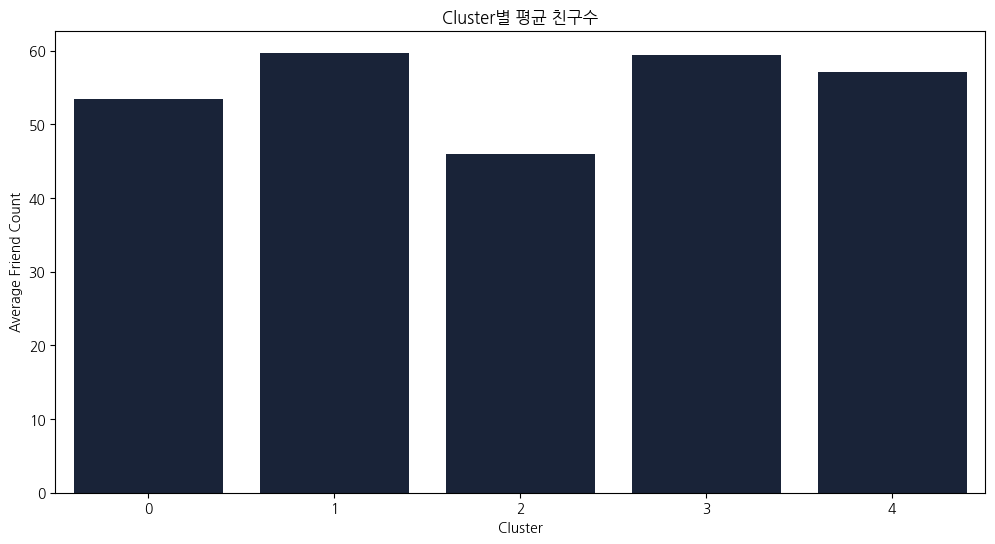

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
plt.figure(figsize=(12, 6))
sns.barplot(x='cluster', y='friend_count', data=friend_summary, color='#14213d')
plt.title("Cluster별 평균 친구수")
plt.xlabel("Cluster")
plt.ylabel("Average Friend Count")
plt.show()

In [234]:
event_summary= df.groupby('cluster')['event_count'].mean().reset_index()

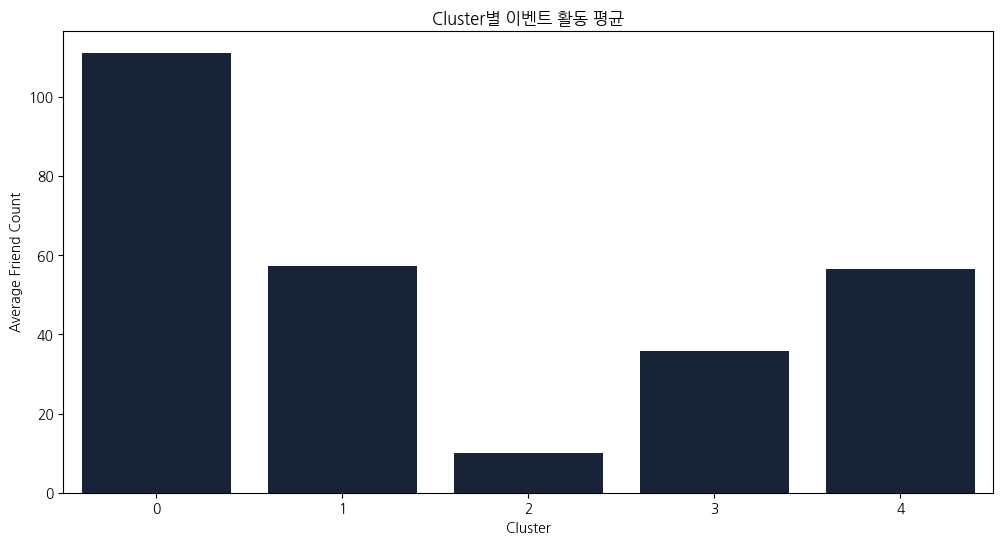

In [235]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
plt.figure(figsize=(12, 6))
sns.barplot(x='cluster', y='event_count', data=event_summary, color='#14213d')
plt.title("Cluster별 이벤트 활동 평균")
plt.xlabel("Cluster")
plt.ylabel("Average Friend Count")
plt.show()

In [236]:
os_summary= df.groupby(['cluster', 'osname']).size().unstack(fill_value=0)

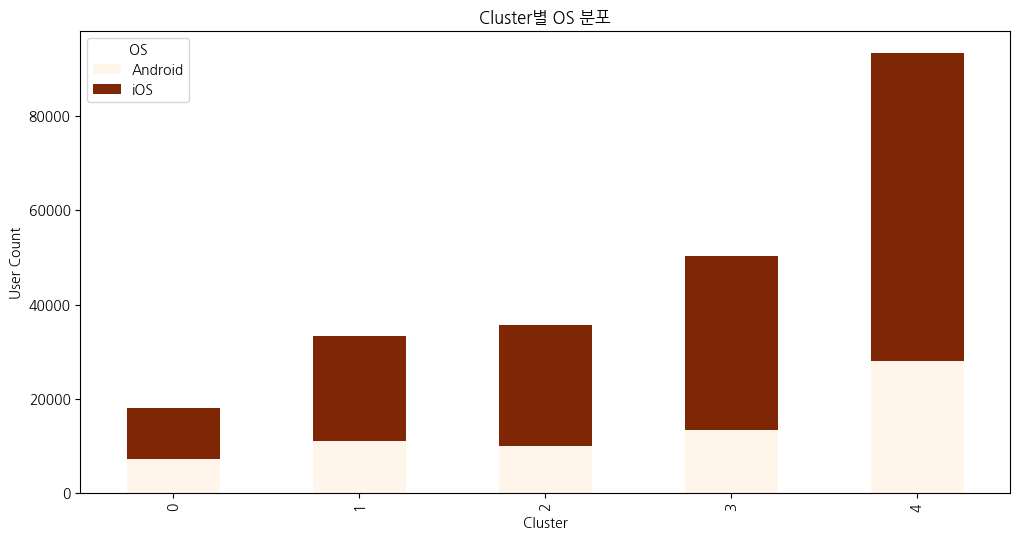

In [237]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
# os_summary가 인덱스가 cluster인 데이터프레임
os_summary.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Oranges')

plt.title("Cluster별 OS 분포")
plt.xlabel("Cluster")
plt.ylabel("User Count")
plt.legend(title="OS")
plt.show()

In [238]:
class_summary= df.groupby(['cluster', 'class']).size().unstack(fill_value=0)

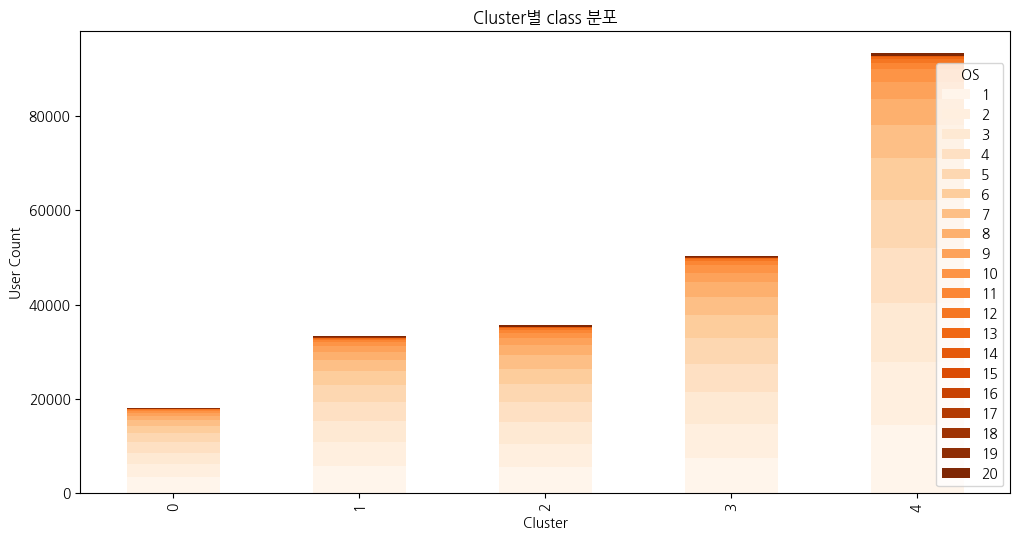

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

class_summary.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Oranges')

plt.title("Cluster별 class 분포")
plt.xlabel("Cluster")
plt.ylabel("User Count")
plt.legend(title="OS")
plt.show()

In [240]:
gender_summary= df.groupby(['cluster', 'gender']).size().unstack(fill_value=0)

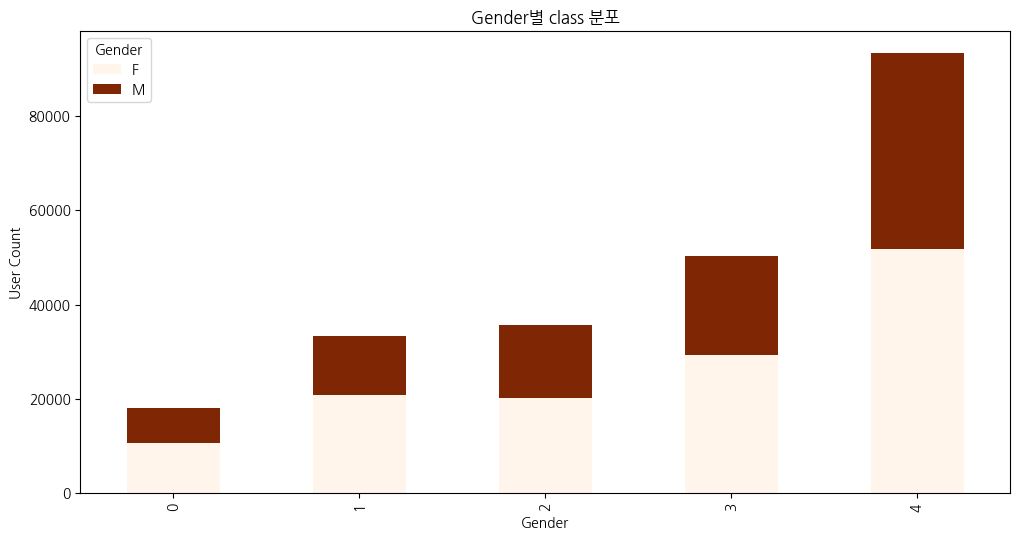

In [241]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

gender_summary.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Oranges')

plt.title("Gender별 class 분포")
plt.xlabel("Gender")
plt.ylabel("User Count")
plt.legend(title="Gender")
plt.show()

In [242]:
grade_summary= df.groupby(['cluster', 'grade']).size().unstack(fill_value=0)
grade_summary

grade,1,2,3
cluster,,,
0,4285,8531,5340
1,8390,15454,9551
2,10362,15282,9937
3,14642,20662,15062
4,29078,36820,27374


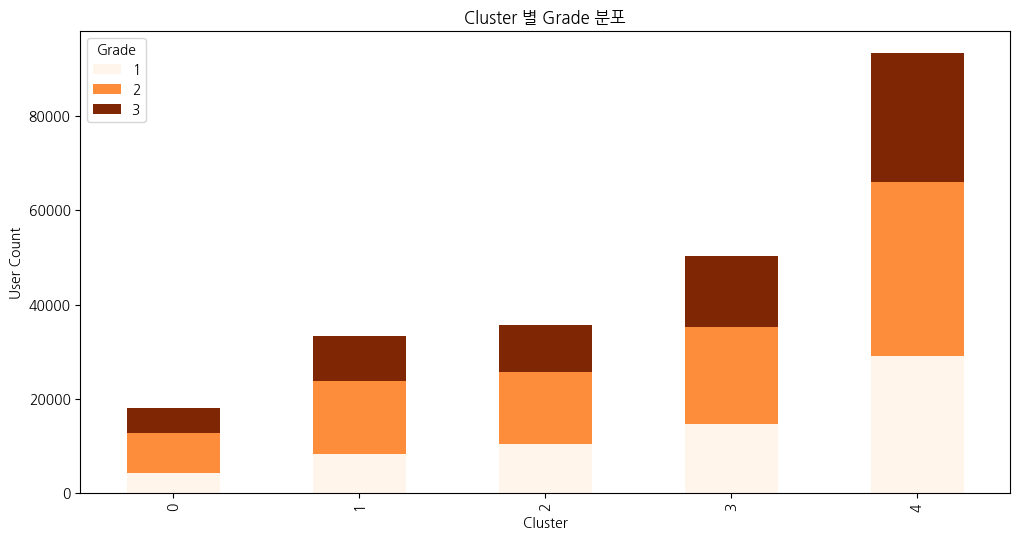

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

grade_summary.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Oranges')

plt.title("Cluster 별 Grade 분포")
plt.xlabel("Cluster")
plt.ylabel("User Count")
plt.legend(title="Grade")
plt.show()

##유저 데이터에 재충전 여부 데이터 결합 => 통합 데이터 만들기

In [244]:
recharge_df= pd.read_csv('/content/drive/MyDrive/고급프로젝트/user_recharge.csv')
recharge_df.dtypes

,0
user_id,int64
did_recharge,bool


In [245]:
df.dtypes

,0
user_id,object
cluster,int32
signup_date,datetime64[ms]
last_login,datetime64[ms]
event_count,int64
friend_count,float64
osname,object
osversion,object
class,int64
gender,object


In [246]:
df['user_id'] = df['user_id'].astype(str)
recharge_df['user_id'] = recharge_df['user_id'].astype(str)

In [247]:
final= pd.merge(df, recharge_df, on='user_id', how='left')
final

,user_id,cluster,signup_date,last_login,event_count,friend_count,osname,osversion,class,gender,grade,school_id,did_recharge
0,1000000,2,2023-07-31 02:35:55,2023-07-31 02:35:55,2,41.0,iOS,16.6,1,M,1,1885,NaN
1,1000009,2,2023-07-19 21:01:30,2023-07-27 11:34:41,5,45.0,Android,12,10,F,2,3869,NaN
2,1000012,4,2023-07-26 22:08:04,2023-08-09 21:21:49,25,26.0,Android,13,10,F,1,5091,NaN
3,1000013,4,2023-07-19 21:56:46,2023-08-01 20:31:13,66,93.0,iOS,16.5.1,8,F,2,1743,True
4,1000015,3,2023-07-20 20:49:04,2023-07-20 20:50:30,23,115.0,iOS,16.5.1,2,F,3,5078,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230765,999987,2,2023-07-25 10:16:18,2023-07-25 10:16:18,2,19.0,iOS,16.5.1,4,F,3,4527,NaN
230766,999990,1,2023-07-23 03:17:20,2023-07-30 02:45:58,24,118.0,iOS,16.5.1,3,F,2,5104,False
230767,999992,0,2023-07-18 21:23:02,2023-08-04 21:34:35,134,12.0,Android,13,1,M,2,2240,NaN
230768,999996,1,2023-07-21 11:20:16,2023-07-21 11:20:25,3,44.0,Android,13,5,M,2,365,NaN


In [248]:
final['did_recharge'].value_counts()

,count
did_recharge,
True,29358
False,9634


In [249]:
# "충전여부를 기록하지 않은 유저 = 충전 안함으로 간주"
final['did_recharge'].fillna(False, inplace=True)

/tmp/ipython-input-249-1643509705.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipython-input-249-1643509705.py:2: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [250]:
final.info(), final.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230770 entries, 0 to 230769
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       230770 non-null  object        
 1   cluster       230770 non-null  int32         
 2   signup_date   230770 non-null  datetime64[ms]
 3   last_login    230770 non-null  datetime64[ms]
 4   event_count   230770 non-null  int64         
 5   friend_count  230770 non-null  float64       
 6   osname        230770 non-null  object        
 7   osversion     230770 non-null  object        
 8   class         230770 non-null  int64         
 9   gender        230770 non-null  object        
 10  grade         230770 non-null  int64         
 11  school_id     230770 non-null  int64         
 12  did_recharge  230770 non-null  bool          
dtypes: bool(1), datetime64[ms](2), float64(1), int32(1), int64(4), object(4)
memory usage: 20.5+ MB


(None,
              cluster                 signup_date                  last_login  \
 count  230770.000000                      230770                      230770   
 mean        2.724544  2023-07-25 20:37:45.886000  2023-07-31 17:30:49.032000   
 min         0.000000         2023-07-18 00:00:00         2023-07-18 00:00:16   
 25%         2.000000  2023-07-20 14:11:43.500000  2023-07-25 18:20:27.250000   
 50%         3.000000         2023-07-23 17:59:36         2023-08-01 17:46:09   
 75%         4.000000  2023-07-29 18:48:49.750000         2023-08-06 20:16:11   
 max         4.000000         2023-08-10 23:59:54         2023-08-10 23:59:59   
 std         1.330195                         NaN                         NaN   
 
          event_count   friend_count          class          grade  \
 count  230770.000000  230770.000000  230770.000000  230770.000000   
 mean       49.268254      56.003575       4.595142       2.002197   
 min         1.000000       0.000000       1.000000 

In [251]:
# 통합 데이터
Data= final.copy()

## 기존의 통합 데이터에서 5일 기준으로 이탈율과 유지율 구하기

In [252]:
observation_end = Data['last_login'].max()
from datetime import timedelta
# 가입 후  5일 이내에 한번이라도 로그인한 적이 있는지 여부 → 유지
DF_eligible = Data[Data['signup_date'] + timedelta(days=5) <= observation_end]
DF_eligible['is_retained'] = (
    DF_eligible['last_login'] <= DF_eligible['signup_date'] + timedelta(days=5)
).astype(int)

# 이탈은 반대
DF_eligible['is_churned'] = 1 - DF_eligible['is_retained']

/tmp/ipython-input-252-486004297.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-252-486004297.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [253]:
DF_eligible

,user_id,cluster,signup_date,last_login,event_count,friend_count,osname,osversion,class,gender,grade,school_id,did_recharge,is_retained,is_churned
0,1000000,2,2023-07-31 02:35:55,2023-07-31 02:35:55,2,41.0,iOS,16.6,1,M,1,1885,False,1,0
1,1000009,2,2023-07-19 21:01:30,2023-07-27 11:34:41,5,45.0,Android,12,10,F,2,3869,False,0,1
2,1000012,4,2023-07-26 22:08:04,2023-08-09 21:21:49,25,26.0,Android,13,10,F,1,5091,False,0,1
3,1000013,4,2023-07-19 21:56:46,2023-08-01 20:31:13,66,93.0,iOS,16.5.1,8,F,2,1743,True,0,1
4,1000015,3,2023-07-20 20:49:04,2023-07-20 20:50:30,23,115.0,iOS,16.5.1,2,F,3,5078,False,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230765,999987,2,2023-07-25 10:16:18,2023-07-25 10:16:18,2,19.0,iOS,16.5.1,4,F,3,4527,False,1,0
230766,999990,1,2023-07-23 03:17:20,2023-07-30 02:45:58,24,118.0,iOS,16.5.1,3,F,2,5104,False,0,1
230767,999992,0,2023-07-18 21:23:02,2023-08-04 21:34:35,134,12.0,Android,13,1,M,2,2240,False,0,1
230768,999996,1,2023-07-21 11:20:16,2023-07-21 11:20:25,3,44.0,Android,13,5,M,2,365,False,1,0


In [254]:
summary =DF_eligible.groupby('cluster').agg({
    'did_recharge': 'mean',
    'is_retained': 'mean',
    'is_churned': 'mean',
    'user_id': 'count',
    'friend_count': 'mean',
    'event_count': 'mean',
    'osname': lambda x: (x == 'iOS').sum() / len(x),
    'gender': lambda x: (x == 'F').sum() / len(x)
}).reset_index().rename(columns={'user_id':'user_count'})

# 🔟 결과 출력
summary

,cluster,did_recharge,is_retained,is_churned,user_count,friend_count,event_count,osname,gender
0,0,0.252729,0.341173,0.658827,17220,53.813937,114.897038,0.591347,0.583682
1,1,0.193883,0.526281,0.473719,30307,59.975715,59.901541,0.662223,0.624641
2,2,0.043902,0.705207,0.294793,32823,46.968680,10.571276,0.718429,0.571459
3,3,0.117887,0.633085,0.366915,47308,59.938023,36.798427,0.731103,0.583453
4,4,0.130225,0.530194,0.469806,83924,57.777215,58.500965,0.694223,0.558648


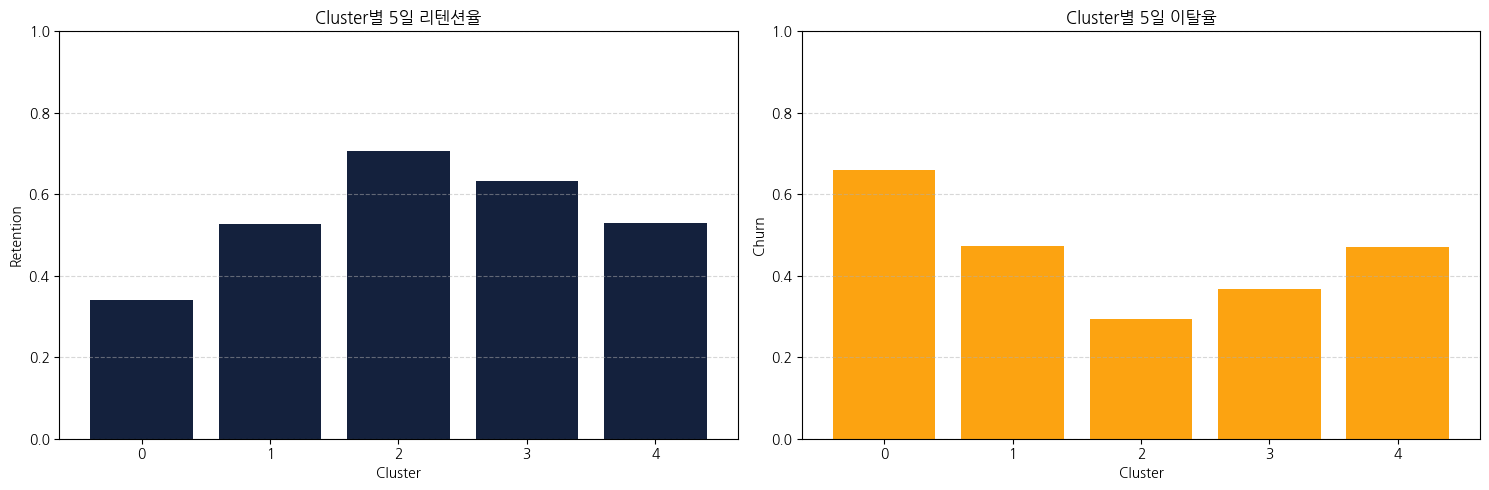

In [255]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.bar(summary['cluster'], summary['is_retained'], color='#14213d')
plt.title("Cluster별 5일 리텐션율")
plt.xlabel("Cluster")
plt.ylabel("Retention")
plt.ylim(0, 1)
plt.xticks(summary['cluster'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.subplot(1,2,2)
plt.bar(summary['cluster'], summary['is_churned'], color='#fca311')
plt.title("Cluster별 5일 이탈율")
plt.xlabel("Cluster")
plt.ylabel("Churn")
plt.ylim(0, 1)
plt.xticks(summary['cluster'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


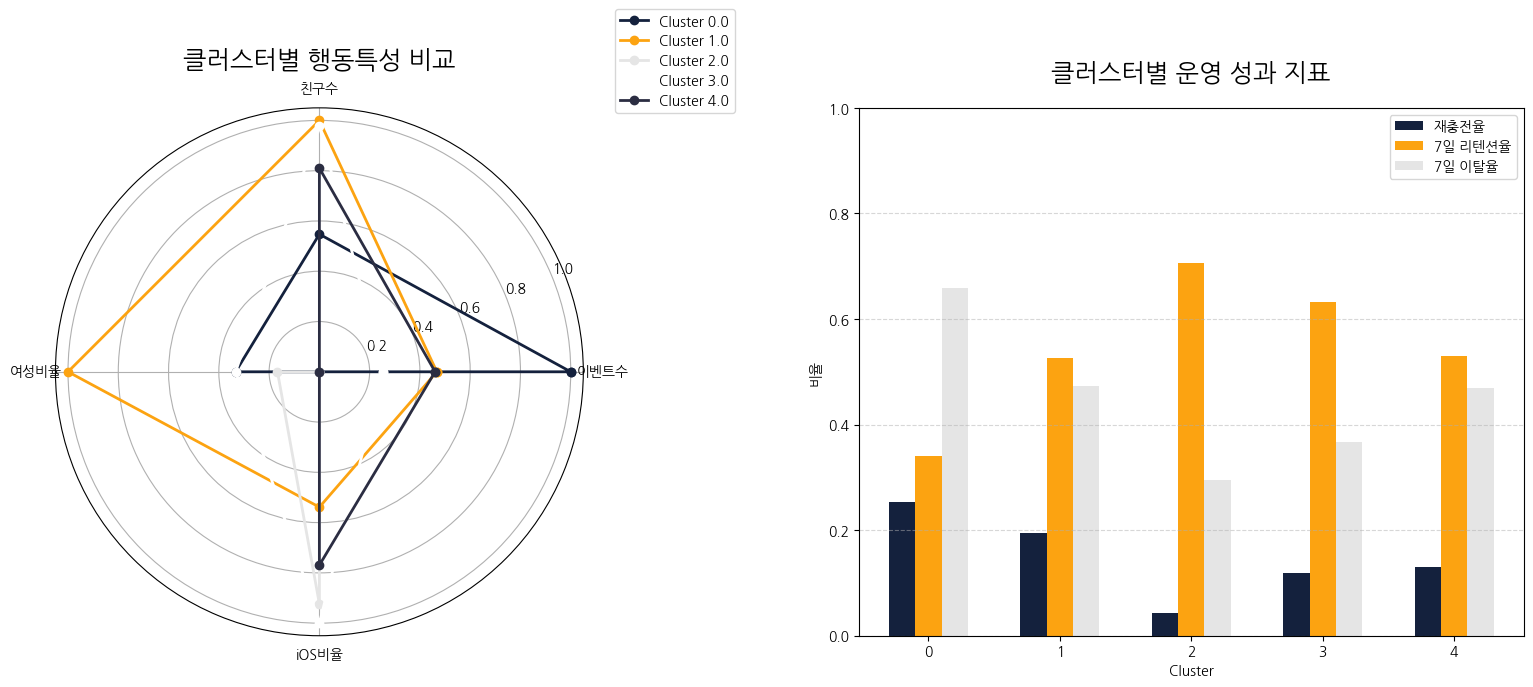

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 샘플 데이터 (너 데이터에 맞게 그대로 넣으면 됨)
data = {
    'cluster': [0, 1, 2, 3, 4],
    'event_count': [111.1, 57.3, 10.1, 35.7, 56.6],
    'friend_count': [53.5, 59.7, 46.0, 59.4, 57.1],
    'female_ratio': [0.58, 0.62, 0.57, 0.58, 0.56],
    'ios_ratio': [0.60, 0.67, 0.72, 0.73, 0.70],
    'did_recharge': [0.26, 0.20, 0.05, 0.12, 0.14],
    'is_retained': [0.36, 0.54, 0.72, 0.65, 0.53],
    'is_churned': [0.64, 0.46, 0.28, 0.35, 0.47]
}

df = pd.DataFrame(data)

# Radar chart 정규화
df_norm = df.copy()
for col in ['event_count', 'friend_count', 'female_ratio', 'ios_ratio']:
    df_norm[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

labels = ['event_count', 'friend_count', 'female_ratio', 'ios_ratio']
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(16, 7))

# 📌 좌측: Radar Chart
plt.subplot(1,2,1, polar=True)
colors = ['#14213d', '#fca311', '#e5e5e5', '#ffffff', '#2b2d42']
for i in range(len(df_norm)):
    values = df_norm.iloc[i][labels].tolist()
    values += values[:1]
    plt.polar(angles, values, marker='o', label=f'Cluster {df_norm.iloc[i]["cluster"]}', color=colors[i], linewidth=2)
plt.xticks(angles[:-1], ['이벤트수', '친구수', '여성비율', 'iOS비율'], fontsize=10)
plt.title('클러스터별 행동특성 비교', fontsize=18, pad= 30)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.2))

# 📌 우측: 운영지표 막대그래프
x = np.arange(len(summary['cluster']))
bar_width = 0.2

plt.subplot(1,2,2)
plt.bar(x - bar_width, summary['did_recharge'], width=bar_width, label='재충전율', color='#14213d')
plt.bar(x, summary['is_retained'], width=bar_width, label='7일 리텐션율', color='#fca311')
plt.bar(x + bar_width, summary['is_churned'], width=bar_width, label='7일 이탈율', color='#e5e5e5')
plt.xticks(x, summary['cluster'])
plt.ylim(0, 1)
plt.title('클러스터별 운영 성과 지표', fontsize=18, pad= 20)
plt.xlabel('Cluster')
plt.ylabel('비율')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()



| Cluster | 특징                 | 간단 요약         |
| ------- | ------------------ | ------------- |
| 0       | 활동량 높음, 이탈 많음      | 헤비 but Churn  |
| 1       | 친구 많고 여성 많음        | 소셜 성향         |
| 2       | 활동 적고 과금 안함, 유지 잘함 | 소극적 but loyal |
| 3       | 전반적 균형             | 적당히 과금+유지     |
| 4       | 평균                 | 무난            |


### 행동 데이터 불러오기

In [257]:
result_df= pd.read_csv('/content/drive/MyDrive/고급프로젝트/events.csv')
result_df

,session_id,event_key_prev,event_datetime_prev,heart_balance_prev,event_key,event_datetime,heart_balance,heart_balance_diff,user_id
0,001398E9-BBCE-4F6E-A669-6A9D72C77CE5,view_login,2023-07-23 17:51:05,95.0,click_bottom_navigation_questions,2023-07-23 17:51:13,108.0,13.0,1172696
1,001398E9-BBCE-4F6E-A669-6A9D72C77CE5,view_shop,2023-07-23 17:53:28,108.0,click_attendance,2023-07-23 17:53:32,12.0,-96.0,1172696
2,001398E9-BBCE-4F6E-A669-6A9D72C77CE5,view_shop,2023-07-23 17:53:44,12.0,click_purchase,2023-07-23 17:53:45,212.0,200.0,1172696
3,0014f001-4757-48cf-a626-6bf17e910d26,$session_start,2023-07-21 20:09:10,1891.0,click_appbar_alarm_center,2023-07-21 20:09:18,2184.0,293.0,1115814
4,0018ED87-EA58-43B1-9C77-B0809BE89B85,$session_start,2023-07-19 11:01:05,323.0,click_bottom_navigation_questions,2023-07-19 11:01:09,86.0,-237.0,1037318
...,...,...,...,...,...,...,...,...,...
74916,zzMKV6lSglYfjuAqqBa1vX3eoGN2,launch_app,2023-07-26 17:11:34,5054.0,click_bottom_navigation_timeline,2023-07-26 17:11:38,5254.0,200.0,1320169
74917,zzeFmOTzkLPa4kJ9kWsWnWRJPML2,launch_app,2023-07-18 20:09:21,11793.0,click_bottom_navigation_timeline,2023-07-18 20:09:27,10374.0,-1419.0,1009630
74918,zzmejla6kTSFw2iDl00M44BPRMb2,view_login,2023-08-03 00:03:34,8421.0,view_timeline_tap,2023-08-03 00:03:41,8860.0,439.0,1099705
74919,zzp5kLCeZNgz4dbwZaQ2s7Bqrhc2,view_shop,2023-08-07 22:53:07,2896.0,click_purchase,2023-08-07 22:53:09,104.0,-2792.0,992825


In [258]:
behavior_pivot = (
    result_df.groupby(['user_id', 'event_key'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
behavior_pivot

event_key,user_id,$session_end,$session_start,click_appbar_alarm_center,click_appbar_chat_rooms,click_appbar_friend_plus,click_appbar_setting,click_attendance,click_bottom_navigation_lab,click_bottom_navigation_profile,...,complete_signup,launch_app,skip_question,view_lab_tap,view_login,view_profile_tap,view_questions_tap,view_shop,view_signup,view_timeline_tap
0,834127,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,834325,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,835713,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,836055,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,836334,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38950,1579913,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38951,1579919,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38952,1579923,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
38953,1579925,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [259]:
behavior_pivot.shape, behavior_pivot.describe

((38955, 37),
 <bound method NDFrame.describe of event_key  user_id  $session_end  $session_start  click_appbar_alarm_center  \
 0           834127             0               0                          0   
 1           834325             0               0                          0   
 2           835713             0               0                          0   
 3           836055             0               0                          0   
 4           836334             0               0                          0   
 ...            ...           ...             ...                        ...   
 38950      1579913             0               0                          0   
 38951      1579919             0               0                          1   
 38952      1579923             0               0                          0   
 38953      1579925             0               0                          0   
 38954      1579929             0               0                       

### 5일을 기준으로 이탈율과 리텐션을 구한 데이터 불러오기

In [260]:
DF5= pd.read_csv('/content/drive/MyDrive/고급프로젝트/DF5.csv')
DF5

,user_id,class,gender,grade,school_id,cluster,signup_date,last_login,event_count,friend_count,osname,osversion,did_recharge,is_churned,is_retained
0,1000000,1,M,1,1885,2,2023-07-31 02:35:55,2023-07-31 02:35:55,2,41.0,iOS,16.6,False,0,1
1,1000009,10,F,2,3869,2,2023-07-19 21:01:30,2023-07-27 11:34:41,5,45.0,Android,12,False,1,0
2,1000012,10,F,1,5091,4,2023-07-26 22:08:04,2023-08-09 21:21:49,25,26.0,Android,13,False,1,0
3,1000013,8,F,2,1743,4,2023-07-19 21:56:46,2023-08-01 20:31:13,66,93.0,iOS,16.5.1,True,1,0
4,1000015,2,F,3,5078,3,2023-07-20 20:49:04,2023-07-20 20:50:30,23,115.0,iOS,16.5.1,False,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211577,999987,4,F,3,4527,2,2023-07-25 10:16:18,2023-07-25 10:16:18,2,19.0,iOS,16.5.1,False,0,1
211578,999990,3,F,2,5104,1,2023-07-23 03:17:20,2023-07-30 02:45:58,24,118.0,iOS,16.5.1,False,1,0
211579,999992,1,M,2,2240,0,2023-07-18 21:23:02,2023-08-04 21:34:35,134,12.0,Android,13,False,1,0
211580,999996,5,M,2,365,1,2023-07-21 11:20:16,2023-07-21 11:20:25,3,44.0,Android,13,False,0,1


In [261]:
DF5.isnull().sum()

,0
user_id,0
class,0
gender,0
grade,0
school_id,0
cluster,0
signup_date,0
last_login,0
event_count,0
friend_count,0


### 행동 변수 데이터와 5일 필터링 데이터 합치기

In [262]:
merged_df= pd.merge(DF5, behavior_pivot, on= 'user_id', how= 'inner')
merged_df

,user_id,class,gender,grade,school_id,cluster,signup_date,last_login,event_count,friend_count,...,complete_signup,launch_app,skip_question,view_lab_tap,view_login,view_profile_tap,view_questions_tap,view_shop,view_signup,view_timeline_tap
0,1000013,8,F,2,1743,4,2023-07-19 21:56:46,2023-08-01 20:31:13,66,93.0,...,0,0,0,0,0,0,0,0,0,0
1,1000030,7,F,2,5278,0,2023-07-18 20:55:37,2023-08-07 01:36:08,220,31.0,...,0,0,0,0,0,0,0,0,0,0
2,1000069,10,F,2,1824,4,2023-07-20 21:53:11,2023-08-03 12:23:52,49,107.0,...,0,2,0,0,0,0,0,0,0,1
3,1000079,4,M,1,99,0,2023-07-19 16:08:02,2023-08-08 22:25:38,131,17.0,...,0,1,0,1,0,0,0,1,0,0
4,1000132,7,F,2,4845,0,2023-08-02 22:28:42,2023-08-02 23:09:19,30,58.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37190,999920,1,M,2,3869,1,2023-07-23 23:11:05,2023-08-06 06:16:44,62,71.0,...,0,0,0,0,0,0,0,0,0,0
37191,999940,11,F,1,4645,3,2023-07-18 18:40:49,2023-07-18 19:34:54,12,55.0,...,0,0,0,0,0,0,0,0,0,0
37192,999946,5,F,1,1998,3,2023-07-19 01:43:02,2023-07-30 23:52:56,37,31.0,...,0,0,0,0,0,0,0,0,0,0
37193,999976,8,F,2,4453,4,2023-07-18 12:36:25,2023-08-08 15:22:40,50,26.0,...,0,1,0,0,0,0,0,0,0,0


In [263]:
merged_df['signup_date']= pd.to_datetime(merged_df['signup_date'])
merged_df['last_login']= pd.to_datetime(merged_df['last_login'])
merged_df.dtypes

,0
user_id,int64
class,int64
gender,object
grade,int64
school_id,int64
cluster,int64
signup_date,datetime64[ns]
last_login,datetime64[ns]
event_count,int64
friend_count,float64


In [264]:
merged_df.columns

Index(['user_id', 'class', 'gender', 'grade', 'school_id', 'cluster',
       'signup_date', 'last_login', 'event_count', 'friend_count', 'osname',
       'osversion', 'did_recharge', 'is_churned', 'is_retained',
       '$session_end', '$session_start', 'click_appbar_alarm_center',
       'click_appbar_chat_rooms', 'click_appbar_friend_plus',
       'click_appbar_setting', 'click_attendance',
       'click_bottom_navigation_lab', 'click_bottom_navigation_profile',
       'click_bottom_navigation_questions', 'click_bottom_navigation_timeline',
       'click_friend_invite', 'click_invite_friend', 'click_notice_detail',
       'click_profile_ask', 'click_purchase', 'click_question_ask',
       'click_question_open', 'click_question_share', 'click_question_start',
       'click_random_ask_normal', 'click_random_ask_other',
       'click_random_ask_shuffle', 'click_timeline_chat_start',
       'complete_purchase', 'complete_question', 'complete_signup',
       'launch_app', 'skip_question', 

### 클러스터별 Aha Moment 찾기

In [265]:
behavior_cols = [col for col in merged_df.columns if col.startswith(('click_', 'view_', 'complete_', 'launch_app', 'skip_question'))]
behavior_cols


['click_appbar_alarm_center',
 'click_appbar_chat_rooms',
 'click_appbar_friend_plus',
 'click_appbar_setting',
 'click_attendance',
 'click_bottom_navigation_lab',
 'click_bottom_navigation_profile',
 'click_bottom_navigation_questions',
 'click_bottom_navigation_timeline',
 'click_friend_invite',
 'click_invite_friend',
 'click_notice_detail',
 'click_profile_ask',
 'click_purchase',
 'click_question_ask',
 'click_question_open',
 'click_question_share',
 'click_question_start',
 'click_random_ask_normal',
 'click_random_ask_other',
 'click_random_ask_shuffle',
 'click_timeline_chat_start',
 'complete_purchase',
 'complete_question',
 'complete_signup',
 'launch_app',
 'skip_question',
 'view_lab_tap',
 'view_login',
 'view_profile_tap',
 'view_questions_tap',
 'view_shop',
 'view_signup',
 'view_timeline_tap']

In [266]:
cluster_list = merged_df['cluster'].unique()
cluster_list

array([4, 0, 1, 3, 2])

In [267]:
import pandas as pd
from scipy.stats import ttest_ind

result_list = []

for cluster in cluster_list:
    cluster_df = merged_df[merged_df['cluster'] == cluster]

    for feature in behavior_cols:
        retained_values = cluster_df[cluster_df['is_retained'] == 1][feature]
        churned_values = cluster_df[cluster_df['is_retained'] == 0][feature]

        t_stat, p_value = ttest_ind(retained_values, churned_values, equal_var=False, nan_policy='omit')

        gap = retained_values.mean() - churned_values.mean()
        activity_rate = max(retained_values.mean(), churned_values.mean())

        result_list.append({
            'cluster': cluster,
            'feature': feature,
            'Retained_mean': retained_values.mean(),
            'Churned_mean': churned_values.mean(),
            'gap': gap,
            'p_value': p_value,
            'activity_rate': activity_rate
        })

aha_result = pd.DataFrame(result_list)
aha_result


,cluster,feature,Retained_mean,Churned_mean,gap,p_value,activity_rate
0,4,click_appbar_alarm_center,0.092334,0.119005,-0.026670,3.537057e-06,0.119005
1,4,click_appbar_chat_rooms,0.036585,0.061344,-0.024758,5.776766e-09,0.061344
2,4,click_appbar_friend_plus,0.003733,0.007814,-0.004081,1.436620e-03,0.007814
3,4,click_appbar_setting,0.000000,0.000000,0.000000,NaN,0.000000
4,4,click_attendance,0.095819,0.164721,-0.068902,5.002911e-24,0.164721
...,...,...,...,...,...,...,...
165,2,view_profile_tap,0.000000,0.006949,-0.006949,1.544758e-03,0.006949
166,2,view_questions_tap,0.000000,0.004170,-0.004170,1.425507e-02,0.004170
167,2,view_shop,0.005168,0.009034,-0.003866,3.821184e-01,0.009034
168,2,view_signup,0.000000,0.000000,0.000000,NaN,0.000000


In [268]:
# Aha score 계산
epsilon = 1e-8
aha_result['aha_score'] = (aha_result['gap'] * aha_result['activity_rate']) / (aha_result['p_value'] + epsilon)

In [269]:
# p-value 유의미한 것만 보기
aha_result_final = aha_result[aha_result['p_value'] <= 0.05]

# 클러스터별 aha score 상위부터 정렬
aha_result_final = aha_result_final.sort_values(['cluster', 'aha_score'], ascending=[True, False])

# 결과 확인
aha_result_final

,cluster,feature,Retained_mean,Churned_mean,gap,p_value,activity_rate,aha_score
47,0,click_purchase,0.214623,0.150783,0.063840,1.130179e-03,0.214623,1.212314e+01
64,0,view_questions_tap,0.000000,0.000895,-0.000895,4.548817e-02,0.000895,-1.760380e-05
63,0,view_profile_tap,0.005896,0.014094,-0.008198,1.008520e-02,0.014094,-1.145623e-02
42,0,click_bottom_navigation_timeline,0.048349,0.066890,-0.018541,2.748907e-02,0.066890,-4.511741e-02
67,0,view_timeline_tap,0.100236,0.125951,-0.025715,3.464700e-02,0.125951,-9.348039e-02
43,0,click_friend_invite,0.000000,0.003356,-0.003356,1.063675e-04,0.003356,-1.058565e-01
61,0,view_lab_tap,0.038915,0.059955,-0.021040,9.555566e-03,0.059955,-1.320138e-01
59,0,launch_app,0.167453,0.220582,-0.053129,1.398181e-03,0.220582,-8.381720e+00
40,0,click_bottom_navigation_profile,0.020047,0.051678,-0.031631,2.790947e-07,0.051678,-5.654223e+03
35,0,click_appbar_chat_rooms,0.038915,0.099553,-0.060637,1.758335e-09,0.099553,-5.133904e+05


In [273]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

def aha_analysis(merged_df, cluster_col='cluster', label_col='is_retained', top_n=3, min_activity_rate=0.01):
    # ① 행동 feature 리스트 추출 (click_, view_, complete_ prefix 기준)
    behavior_cols = [col for col in merged_df.columns if col.startswith(('click_', 'view_', 'complete_', 'launch_app', 'skip_question'))]

    result_list = []

    for cluster in merged_df[cluster_col].unique():
        cluster_df = merged_df[merged_df[cluster_col] == cluster]

        for feature in behavior_cols:
            retained_values = cluster_df[cluster_df[label_col] == 1][feature]
            churned_values = cluster_df[cluster_df[label_col] == 0][feature]

            # 희소성 방어 (데이터가 전부 0일 경우 스킵)
            if retained_values.sum() == 0 and churned_values.sum() == 0:
                continue

            # t-test
            t_stat, p_value = ttest_ind(retained_values, churned_values, equal_var=False, nan_policy='omit')

            gap = retained_values.mean() - churned_values.mean()
            activity_rate = max(retained_values.mean(), churned_values.mean())

            result_list.append({
                'cluster': cluster,
                'feature': feature,
                'Retained_mean': retained_values.mean(),
                'Churned_mean': churned_values.mean(),
                'gap': gap,
                'p_value': p_value,
                'activity_rate': activity_rate
            })

    aha_result = pd.DataFrame(result_list)

    # ② 희소 피쳐 제거 (활동 비율 너무 낮은 피쳐 제외)
    aha_result = aha_result[aha_result['activity_rate'] > min_activity_rate]

    # ③ 안정화된 Aha Score 계산 (log scale p-value 사용)
    epsilon = 1e-8
    aha_result['aha_score_stable'] = (aha_result['gap'] * aha_result['activity_rate']) / (np.log10(aha_result['p_value'] + epsilon) + 10)

    # ④ 전략 추천 붙이기
    def recommend(row):
        if row['gap'] > 0:
            return "이 행동을 유도하자 ✅"
        else:
            return "이 행동을 줄이자 ⚠️"

    aha_result['recommendation'] = aha_result.apply(recommend, axis=1)

    # ⑤ 클러스터별 Top N 추출
    top_aha = (
        aha_result
        .sort_values(['cluster', 'aha_score_stable'], ascending=[True, False])
        .groupby('cluster')
        .head(top_n)
        .reset_index(drop=True)
    )

    return top_aha

In [274]:
# merged_df가 이미 준비되어 있다면
top_aha_result = aha_analysis(merged_df, top_n=5)

# 결과 확인
top_aha_result[['cluster', 'feature', 'gap', 'aha_score_stable', 'recommendation']]


,cluster,feature,gap,aha_score_stable,recommendation
0,0,click_purchase,0.063840,1.942597e-03,이 행동을 유도하자 ✅
1,0,click_question_ask,0.002518,3.653536e-06,이 행동을 유도하자 ✅
2,0,click_question_share,-0.005350,-6.113236e-06,이 행동을 줄이자 ⚠️
3,0,view_shop,-0.003689,-1.208205e-05,이 행동을 줄이자 ⚠️
4,0,view_profile_tap,-0.008198,-1.443567e-05,이 행동을 줄이자 ⚠️
5,1,launch_app,0.021681,6.646571e-04,이 행동을 유도하자 ✅
6,1,click_bottom_navigation_questions,0.005880,5.452524e-05,이 행동을 유도하자 ✅
7,1,view_shop,0.000830,3.665212e-06,이 행동을 유도하자 ✅
8,1,click_question_ask,-0.002381,-2.617705e-06,이 행동을 줄이자 ⚠️
9,1,view_profile_tap,-0.006133,-8.926756e-06,이 행동을 줄이자 ⚠️


/tmp/ipython-input-281-3527352827.py:22: UserWarning:

Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) NanumGothic.

/tmp/ipython-input-281-3527352827.py:22: UserWarning:

Glyph 9888 (\N{WARNING SIGN}) missing from font(s) NanumGothic.

/tmp/ipython-input-281-3527352827.py:22: UserWarning:

Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) NanumGothic.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) NanumGothic.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 9888 (\N{WARNING SIGN}) missing from font(s) NanumGothic.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) NanumGothic.



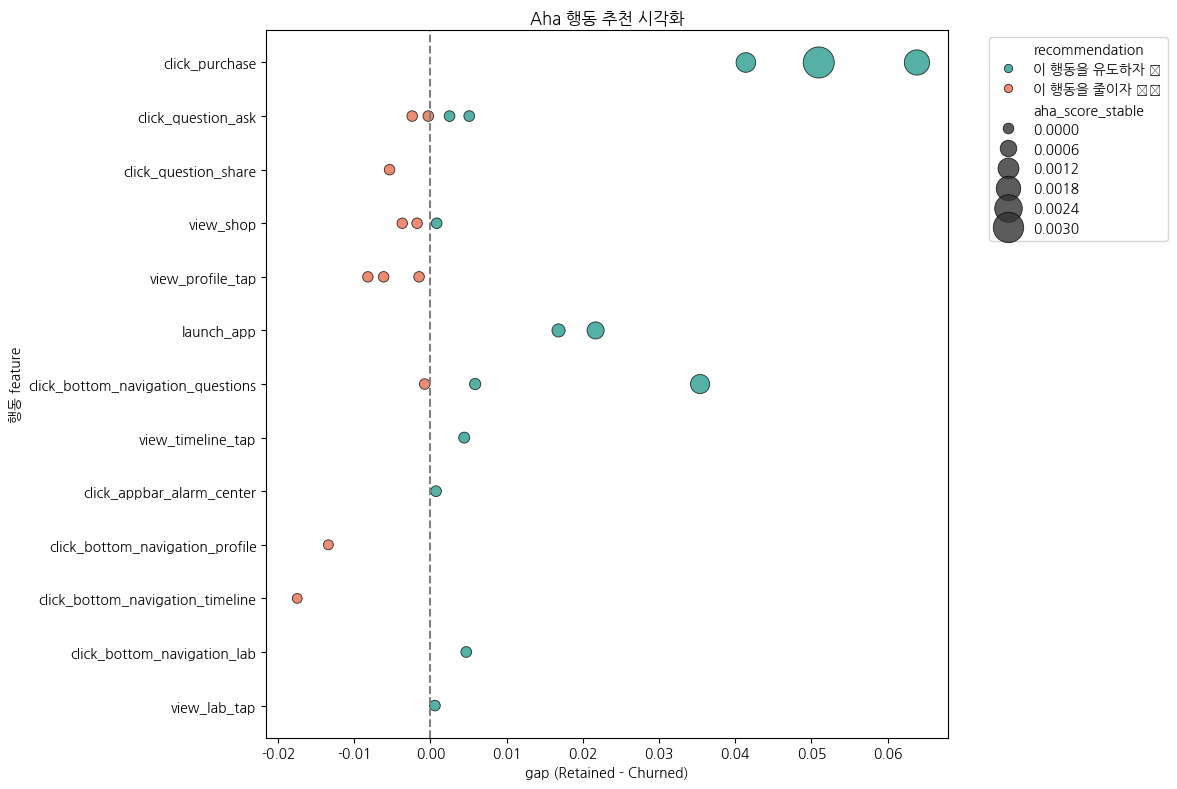

In [281]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
def visualize_aha_recommendation(top_aha_result):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=top_aha_result,
        x='gap',
        y='feature',
        size='aha_score_stable',
        hue='recommendation',
        palette={'이 행동을 유도하자 ✅': '#2a9d8f', '이 행동을 줄이자 ⚠️': '#e76f51'},
        sizes=(50, 500),
        alpha=0.8,
        edgecolor='k'
    )
    plt.axvline(0, color='gray', linestyle='--')
    plt.title('Aha 행동 추천 시각화')
    plt.xlabel('gap (Retained - Churned)')
    plt.ylabel('행동 feature')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 실행
visualize_aha_recommendation(top_aha_result)


AttributeError: 'function' object has no attribute 'shape'